# Análisis de las ventas de cerveza en una cadena de supermercados

### Descripción del problema

En el siguiente análisis vamos a estudiar las ventas de cervezas en una cadena de supermercados durante el mes de Junio de 2018. Para ello contamos con dos ficheros de entrada:

* `master_articles.h5`: contiene la información del maestro de articulos. Tiene los siguientes campos:
 * `Articulo_Codigo` : identificador único del artículo
 * `Articulo_Nombre` : nombre del articulo
 * `GVSV`: categoría a la que pertenece el artículo (cervezas, bebidas refrescantes, café, etc.)
* `beer_sales.h5`: contiene todos los tickets de venta de cervezas (a nivel de línea de ticket). Tiene los siguientes campos:
 * `articulo`: identificador único del artículo comprado
 * `cantidad`: unidades compradas de ese artículo en el ticket
 * `importe`: importe en euros de ese artículo en el ticket
 * `tienda`: identificador único de la tienda donde se produjo la linea de ticket
 * `caja`: identificador de la caja registradora en la que se produjo la linea de ticket
 * `dia`: dia en el que se produjo la linea de ticket
 * `hora`: hora en la que se produjo la linea de ticket
 * `minuto`: minuto en el que se produjo la linea de ticket
 * `ticket`: identificador NO único del ticket (es un identificador del ticket por tienda y caja)

### Desarrollo de la solución

**En primer lugar, nos gustaría traernos el nombre de cada artículo al dataset de tickets.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# En primer lugar leemos los ficheros como dataframes:
beers = pd.read_hdf('C:/Users/asus/Desktop/beer_sales.h5')
master = pd.read_hdf('C:/Users/asus/Desktop/master_articles.h5')

# Para traernos el nombre hacemos un left join entre el dataframe de beers y master usando como pkey el campo 'articulo'
master.rename(columns={'Articulo_Codigo':'articulo'}, inplace=True)
df = beers.merge(master[['Articulo_Nombre', 'articulo']], how='left', on='articulo')
df.head()

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Nombre
0,19519,3,1.0,23,13,6.12,19,137,14808,SAN MIGUEL 12X33cl.
1,19519,3,1.0,29,11,6.12,52,78,14808,SAN MIGUEL 12X33cl.
2,7571,2,6.0,30,18,3.90,37,310,14967,ESTR.GALICIA 33cl.
3,8128,3,1.0,5,13,0.00,44,57,14214,MOLENBIER 33cl.
4,13340,3,1.0,5,13,0.00,44,57,14214,SKOL 33cl.


**Como se ha explicado en la descripción del problema, el campo `ticket` del dataset de ventas no es único. Es decir, puede haber líneas de ticket que compartan valor de `ticket` sin pertenecer necesariamente al mismo ticket. Dada la información disponible, ¿se te ocurre alguna manera de generar un id de ticket que identifique unequívocamente las lineas que pertenecen a un mismo ticket?**

In [2]:
# Para crear una Id única para cada ticket podríamos concatenar los valores de caja, tienda, dia, hora, minuto y ticket.
# Antes debemos pasar a formato string los valores de tienda
df.tienda = df.tienda.astype(str)
df['ticket_id'] = df['tienda']+df['caja']+df['ticket']+df['dia']+df['hora']+df['minuto']
df.head()

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Nombre,ticket_id
0,19519,3,1.0,23,13,6.12,19,137,14808,SAN MIGUEL 12X33cl.,148083137231319
1,19519,3,1.0,29,11,6.12,52,78,14808,SAN MIGUEL 12X33cl.,14808378291152
2,7571,2,6.0,30,18,3.90,37,310,14967,ESTR.GALICIA 33cl.,149672310301837
3,8128,3,1.0,5,13,0.00,44,57,14214,MOLENBIER 33cl.,1421435751344
4,13340,3,1.0,5,13,0.00,44,57,14214,SKOL 33cl.,1421435751344


**¿Se te ocurre alguna manera de verificar que el identificador generado agrupa correctamente las líneas de ticket? ¿Qué consecuencias crees que podría tener el no generarlo correctamente?**

Para verificar que el identificador generado agrupa correctamente las líneas de ticket podemos hacer un conteo de las veces que aparece cada id del articulo en el ticket y comprobar que ninguno aparece más de una vez por ticket

In [3]:
conteo = df.groupby(['ticket_id', 'articulo']).agg({'articulo':'count'}).rename(columns={'articulo':'unicos'}).reset_index()
conteo.loc[conteo.unicos>1].shape

(37, 3)

Vemos que hay 37 casos en los que el mismo producto se compra en la misma caja y tienda y mismo dia, hora y minuto. Para estos casos necesitariamos la informacion de los segundos, y tener así mayor granularidad en la agrupacion.  
Las consecuencias por no generar correctamente el identificador serían principalmente conclusiones erróneas en el análisis sobre hábitos de compra de los clientes, productos más vendidos, etc... pues asignaríamos compras que no corresponden al ticket indicado 

**Ahora, nos gustaría ver en un gráfico las ventas por articulo del TOP 10 de cervezas más vendidas.**

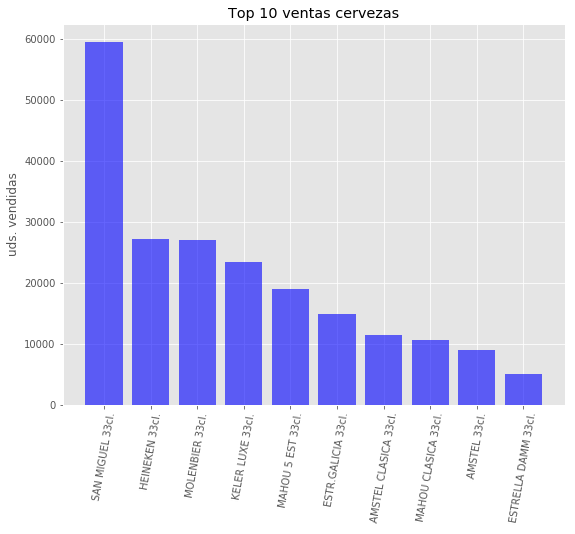

In [23]:
# Agrupamos por nombre y contamos las unidades vendidas para cada cerveza
suma = df.groupby('Articulo_Nombre').agg({'cantidad':'sum'}).reset_index().rename(columns={'cantidad':'top10'})
top = suma.sort_values(by='top10', ascending=False)
topten = top.iloc[0:10]
fig = plt.figure(figsize=(9,7))
plt.bar(topten.Articulo_Nombre, topten.top10, alpha=.6, color='b')
plt.xticks(rotation=80)
plt.ylabel('uds. vendidas')
plt.title('Top 10 ventas cervezas')
plt.grid(True)
plt.show()

**Se han detectado una serie de tickets anómalos en los que la cantidad de cervezas compradas es extremadamente alto. ¿Como harías para detectarlos y filtrarlos de nuestro conjunto de ventas?**

Podemos obtener los percentiles para la variable 'cantidad', y definir como datos anómalos aquellos que superan el valor de 1.5*Rango_Intercuartilico + Q3

In [5]:
 df[['cantidad']].describe()


,cantidad
count,45835.000000
mean,5.165201
std,12.108080
min,-8.000000
25%,1.000000
50%,4.000000
75%,6.000000
max,1596.000000


Por tanto, podriamos considerar anómalos aquellos tickets con mas de 14 unidades compradas para algún artículo. Obviamente aquellos tickets que contengan artículos con cantidades inferiores a 0 habría que filtrarlos también.

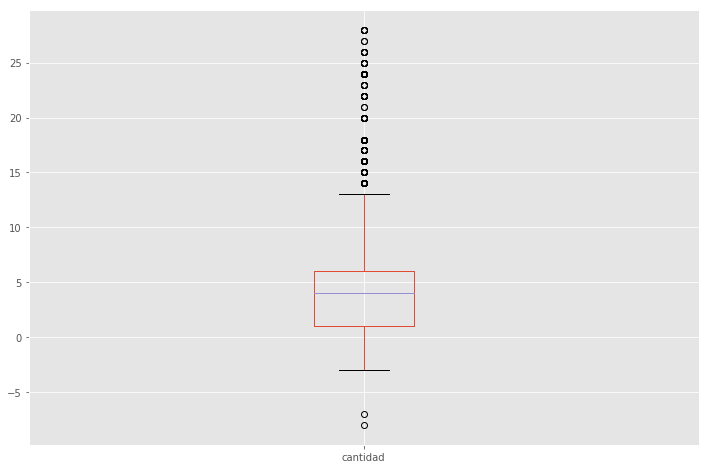

In [18]:
df.loc[df.cantidad < 30].boxplot(column='cantidad', figsize=(12,8))
plt.show()

**¿Se te ocurre alguna manera de automáticamente detectar estos tickets en el futuro? ¿Y algún motivo de su presencia?**

Para detectar de forma automática estos tickets podríamos definir un umbral para la variable cantidad, y cada vez que un artículo superase el umbral tener algún flag que nos avise de ello. Su presencia puede estar motivada por varias razones, puede ser un error al introducir la cantidad de articulos vendidos, una compra puntual masiva para algun tipo de evento o negocio, etc...

**A continuación, nos gustaría analizar qué cervezas se compran juntas más a menudo. Para ello, a partir de los tickets, calcularemos el número de veces que se compran cada par de articulos conjuntamente (en el mismo ticket).**

In [7]:
# En primer lugar creamos una lista con los articulos adquiridos para cada ticket
combinaciones = df.groupby('ticket_id')['articulo'].apply(list).reset_index()
combinaciones.head()

,ticket_id,articulo
0,14018210311158,[10486]
1,140182103141234,[10486]
2,140182108251212,[10486]
3,140182109919,[10486]
4,140182111111245,[7643]


In [8]:
# Y calculamos todas las combinaciones de 2 elementos para los elementos de las listas de articulos
import itertools
combinaciones['long']=combinaciones.articulo.apply(lambda x: len(x))
j1 = combinaciones.loc[combinaciones.long >1]

def combina(lista):
       return list(itertools.combinations(lista,2))


parejas = list(j1.articulo.apply(combina))

In [9]:
# Creamos una lista con todas las tuplas de parejas de articulos y a continuacion almacenamos en un diccionario 
# las veces que se repite cada tupla en la lista:
b1=[item for sublist in parejas for item in sublist]
conjuntos = {i:b1.count(i) for i in b1}
conjuntos

{(10486, 11213): 31,
 (7643, 10486): 29,
 (13340, 8128): 138,
 (7643, 12814): 11,
 (7607, 13340): 6,
 (10486, 7643): 19,
 (7571, 79407): 2,
 (14920, 7571): 9,
 (7571, 10486): 14,
 (13340, 14920): 6,
 (7643, 11213): 34,
 (11213, 7643): 40,
 (35915, 10486): 18,
 (8128, 13340): 137,
 (8128, 11213): 35,
 (14920, 8128): 7,
 (45895, 12814): 11,
 (8128, 8133): 28,
 (7571, 12814): 16,
 (45895, 7571): 12,
 (45895, 10486): 12,
 (7571, 45895): 11,
 (11213, 18495): 49,
 (13340, 7571): 6,
 (7571, 15087): 2,
 (11213, 79971): 6,
 (79407, 7571): 5,
 (11213, 11213): 13,
 (12814, 13340): 6,
 (7643, 7571): 12,
 (13340, 7643): 7,
 (17912, 35915): 3,
 (7571, 7643): 15,
 (17912, 7643): 11,
 (8133, 8128): 23,
 (12814, 7571): 16,
 (45895, 35914): 4,
 (11213, 8128): 32,
 (10486, 45895): 10,
 (8133, 8133): 2,
 (7643, 17912): 8,
 (10486, 35915): 7,
 (79407, 10486): 8,
 (18495, 10486): 4,
 (35914, 10486): 9,
 (7643, 15087): 4,
 (35915, 13340): 2,
 (14920, 14907): 5,
 (8128, 10486): 11,
 (11213, 14920): 9,
 (14920

In [10]:
# Finalmente vemos que clave del diccionario tiene el mayor valor:
import operator

max(conjuntos.items(), key=operator.itemgetter(1))[0]

(13340, 8128)

In [11]:
df.loc[df.articulo.isin(['13340', '8128'])].Articulo_Nombre.unique()

array([' MOLENBIER 33cl.', ' SKOL 33cl.'], dtype=object)

Por tanto las cervezas que mas se venden conjuntamente, son la MOLENBIER 33cl. y SKOL 33cl. Para un calculo más precios habría que asegurarse que todas las tuplas contienen distintos valores, y que no considera distintas aquellas que tienen el orden permutado.


**¿Se te ocurre alguna posible manera de optimizar este cálculo?**

Para optimizar el cálculo podríamos crear un identificador único cuando dos articulos son comprados conjuntamente e ir almacenando las veces que se produce dicha compra cojunta, sin necesidad de almacena todas las combinaciones posibles entre parejas de todas las cervezas.

**¿Qué utilidad crees que puede tener esta información?**

La principal utilidad podría ser lanzar ofertas sobre una de las dos cervezas, y así incentivar a aquellos clientes que solo hayan comprado una de ellas para que compren la cerveza ofertada. O lanzar algún tipo de pack que contenga ambas marcas y tener certeza que va a haber demanda para dicho producto.

**EXTRA: Por último, nos gustaría ver como evoluciona la venta de cervezas a lo largo de la semana y por tramos horarios. ¿Podrías representar esto en un único gráfico? ¿Qué utilidad de negocio crees que tendría esta información segmentada?**

En primer lugar vamos a calcular las unidades vendidad por dia y por hora:

In [12]:
ventas = df.groupby(['dia', 'hora']).agg({'cantidad':'sum'}).reset_index()
ventas.head(10)

,dia,hora,cantidad
0,1,10,1205.0
1,1,11,1120.0
2,1,12,1074.0
3,1,13,870.0
4,1,14,775.0
5,1,15,435.0
6,1,16,590.0
7,1,17,879.0
8,1,18,1208.0
9,1,19,1223.0


Añadimos columnas para el año (2018) y el mes (Junio) y creamos un dataframe con el formato de fecha datetime

In [13]:
ventas['year'] = 2018
ventas['month'] = 6
ventas = ventas.rename(columns={'dia':'day', 'hora':'hour'})
ventas2 = pd.to_datetime(ventas[['year', 'month', 'day', 'hour']])
ventas2.head()

0   2018-06-01 10:00:00
1   2018-06-01 11:00:00
2   2018-06-01 12:00:00
3   2018-06-01 13:00:00
4   2018-06-01 14:00:00
dtype: datetime64[ns]

Concatenamos el dataframe con la fecha y el dataframe con las ventas por dia y por hora y representamos la serie temporal:

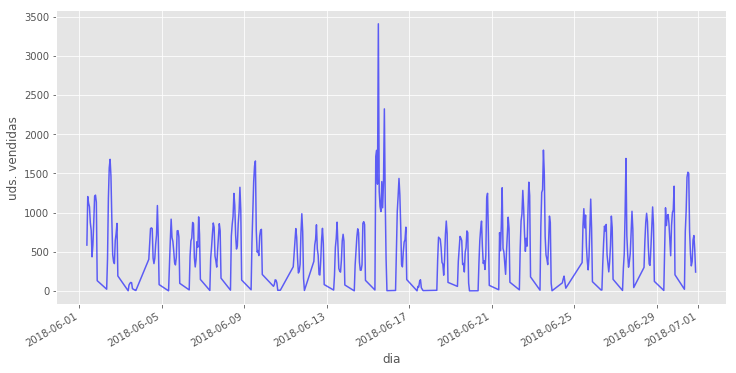

In [15]:
k1 = pd.DataFrame(ventas2)
k1 = k1.rename(columns={0:'dia'})
k2 = pd.concat([k1,ventas[['cantidad']]],axis=1)
k2 = k2.set_index('dia')

fig = plt.figure(figsize=(12,6))
k2.cantidad.plot(c='b', alpha=.6)
plt.ylabel('uds. vendidas')
plt.style.use('ggplot')
plt.grid(True)
plt.show()

Podemos ver que se trata de una serie con componente estacional, sin tendencia clara y con un valor anómalo en torno al 15/06/18. Ese dia se disputó un partido del Mundial 2018
entre España y Portugal, lo cual pudo incrementar las ventas de forma puntual.

**EXTRA: ¿Qué usos de Machine Learning verías aplicables a este conjunto de datos?**

Podríamos estimar las ventas de una marca de cerveza que empiece a distribuirse en una tienda utilizando datos de marcas que ya se estuvieran vendiendo en dicha tienda, utilizando un random forest regressor. Así podríamos decidir si merece la pena comenzar a vender una determinada marca en una determinada tienda.